# **PREPROCESSING**

In [ ]:
import numpy as np
import pandas as pd

# Read dataset file ckd.csv
dataset = pd.read_csv("ckd.csv",header=0, na_values="?")

# Replace null values "?" by numpy.NaN
dataset.replace("?", np.NaN)

# Convert nominal values to binary values
cleanup = {"Rbc":     {"normal": 1, "abnormal": 0},
           "Pc": {"normal": 1, "abnormal": 0},
           "Pcc": {"present": 1, "notpresent": 0},
           "Ba": {"present": 1, "notpresent": 0},
           "Htn": {"yes": 1, "no": 0},
           "Dm": {"yes": 1, "no": 0},
           "Cad": {"yes": 1, "no": 0},
           "Appet": {"good": 1, "poor": 0},
           "pe": {"yes": 1, "no": 0},
           "Ane": {"yes": 1, "no": 0}}

# Replace binary values into dataset
dataset.replace(cleanup, inplace=True)

# Fill null values with mean value of the respective column

dataset.fillna(round(dataset.mean(),2), inplace=True)

# print(dataset)

# Save this dataset as final.csv for further prediction
dataset.to_csv("impckd.csv", sep=',', index=False)

# **CHAID**

In [ ]:
import pandas as pd
train = pd.read_csv("impckd.csv")

In [ ]:
import numpy as np
X = train.drop('class', axis=1)
y = train['class']
X = np.array(X)
y = np.array(y)

In [ ]:
import numpy as np

class Node:

    def __init__(self, feature=None, threshold=None, chi2=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.chi2 = chi2
        self.left = left
        self.right = right
        self.value = value

In [ ]:
class DecisionTree:

    def __init__(self, alpha=0.05, min_samples=3,max_depth=7): #tuning parameters
        self.alpha = alpha # Tuning parameter
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y): #train dt
        self.tree = self._build_tree(X, y) #recursive call


    def predict(self, X):
        y_pred = np.apply_along_axis(lambda x: self._traverse_tree(self.tree, x), 1, X) # (func, axis, array)
        return y_pred

    def _traverse_tree(self, node, x): # traversing the tree
        if node.feature is None:  # leaf node
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(node.left, x)
        else:
            return self._traverse_tree(node.right, x)

    def _build_tree(self, X, y):
        if X.shape[0] <= self.min_samples:
            return Node(value=self._get_leaf_value(y))

        # Split the data into two branches
        best_feature, best_threshold, best_chi2 = self._get_best_split(X, y)
        if best_feature is None:
            return Node(value=self._get_leaf_value(y))

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        left_tree = self._build_tree(X[left_mask], y[left_mask])
        right_tree = self._build_tree(X[right_mask], y[right_mask])

        return Node(feature=best_feature, threshold=best_threshold, chi2=best_chi2, left=left_tree, right=right_tree)
    def _get_best_split(self, X, y):
        best = (None, None, 0)
        thresholds_func = lambda sorted_X: (sorted_X[1:] + sorted_X[:-1]) / 2

        for feature in range(X.shape[1]):
            sorted_X = np.sort(X[:, feature])
            thresholds = thresholds_func(sorted_X)
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples or right_mask.sum() < self.min_samples:
                    continue
                chi2 = self._get_chi2(y, left_mask, right_mask)
                if chi2 > best[2]:
                    best = (feature, threshold, chi2)

        return best if best[0] is not None else (None, None, None)


    def _get_chi2(self, y, left_mask, right_mask):
        observed = np.array([
            [np.sum(y[left_mask] == 0), np.sum(y[left_mask] == 1)],
            [np.sum(y[right_mask] == 0), np.sum(y[right_mask] == 1)]
        ])
        expected = np.array([
            [np.sum(left_mask) * np.sum(y == 0), np.sum(left_mask) * np.sum(y == 1)],
            [np.sum(right_mask) * np.sum(y == 0), np.sum(right_mask) * np.sum(y == 1)]
        ]) / y.shape[0]
        chi2 = np.sum((observed - expected) ** 2 / expected)
        return chi2

    def _get_leaf_value(self, y):
        return np.bincount(y).argmax() # argmax() returns indices of the max element of the array , # bincount() counts the no of values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
classifier = DecisionTree()

In [ ]:
classifier.fit(X_train , y_train)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
TP = np.sum((y_test == 1) & (y_pred == 1))
FP = np.sum((y_test == 0) & (y_pred == 1))
FN = np.sum((y_test == 1) & (y_pred == 0))
TN = np.sum((y_test == 0) & (y_pred == 0))

confusion_matrix = np.array([[TP, FP], [FN, TN]])
print(confusion_matrix)

accuracy= (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
fscore = 2 * (precision * recall) / (precision + recall)

print("Accuracy",accuracy*100,"%")
print("Recall:", recall)
print("Precision:", precision)
print("F-score:", fscore)

[[73  1]
 [ 3 43]]
Accuracy 96.66666666666667 %
Recall: 0.9605263157894737
Precision: 0.9864864864864865
F-score: 0.9733333333333333


# **C5.0**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
data=pd.read_csv('impckd.csv')
data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.810484,1.0,0.0,0.0,121.000000,...,44.0,7800.0,5.200000,1.0,1.0,0.0,1.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.810484,1.0,0.0,0.0,148.036517,...,38.0,6000.0,4.707435,0.0,0.0,0.0,1.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,1.000000,1.0,0.0,0.0,423.000000,...,31.0,7500.0,4.707435,0.0,1.0,0.0,0.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,1.000000,0.0,1.0,0.0,117.000000,...,32.0,6700.0,3.900000,1.0,0.0,0.0,0.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,1.000000,1.0,0.0,0.0,106.000000,...,35.0,7300.0,4.600000,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1.000000,1.0,0.0,0.0,140.000000,...,47.0,6700.0,4.900000,0.0,0.0,0.0,1.0,0.0,0.0,0
396,42.0,70.0,1.025,0.0,0.0,1.000000,1.0,0.0,0.0,75.000000,...,54.0,7800.0,6.200000,0.0,0.0,0.0,1.0,0.0,0.0,0
397,12.0,80.0,1.020,0.0,0.0,1.000000,1.0,0.0,0.0,100.000000,...,49.0,6600.0,5.400000,0.0,0.0,0.0,1.0,0.0,0.0,0
398,17.0,60.0,1.025,0.0,0.0,1.000000,1.0,0.0,0.0,114.000000,...,51.0,7200.0,5.900000,0.0,0.0,0.0,1.0,0.0,0.0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     400 non-null    float64
 1   bp      400 non-null    float64
 2   sg      400 non-null    float64
 3   al      400 non-null    float64
 4   su      400 non-null    float64
 5   rbc     400 non-null    float64
 6   pc      400 non-null    float64
 7   pcc     400 non-null    float64
 8   ba      400 non-null    float64
 9   bgr     400 non-null    float64
 10  bu      400 non-null    float64
 11  sc      400 non-null    float64
 12  sod     400 non-null    float64
 13  pot     400 non-null    float64
 14  hemo    400 non-null    float64
 15  pcv     400 non-null    float64
 16  wbcc    400 non-null    float64
 17  rbcc    400 non-null    float64
 18  htn     400 non-null    float64
 19  dm      400 non-null    float64
 20  cad     400 non-null    float64
 21  appet   400 non-null    float64
 22  pe

In [ ]:
data['class'].unique()

array([1, 0])

In [ ]:
data['class'].value_counts()

1    250
0    150
Name: class, dtype: int64

In [ ]:
le=LabelEncoder()
data['class']=le.fit_transform(data['class'])
data['class']

0      1
1      1
2      1
3      1
4      1
      ..
395    0
396    0
397    0
398    0
399    0
Name: class, Length: 400, dtype: int64

In [ ]:
data['class'].value_counts()

1    250
0    150
Name: class, dtype: int64

In [ ]:
col_names=list(data.columns)
col_names

['age',
 'bp',
 'sg',
 'al',
 'su',
 'rbc',
 'pc',
 'pcc',
 'ba',
 'bgr',
 'bu',
 'sc',
 'sod',
 'pot',
 'hemo',
 'pcv',
 'wbcc',
 'rbcc',
 'htn',
 'dm',
 'cad',
 'appet',
 'pe',
 'ane',
 'class']

In [ ]:
data.shape

(400, 25)

In [ ]:
x=data.iloc[:,0:24]
x

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,0.810484,1.0,0.0,0.0,121.000000,...,15.4,44.0,7800.0,5.200000,1.0,1.0,0.0,1.0,0.0,0.0
1,7.0,50.0,1.020,4.0,0.0,0.810484,1.0,0.0,0.0,148.036517,...,11.3,38.0,6000.0,4.707435,0.0,0.0,0.0,1.0,0.0,0.0
2,62.0,80.0,1.010,2.0,3.0,1.000000,1.0,0.0,0.0,423.000000,...,9.6,31.0,7500.0,4.707435,0.0,1.0,0.0,0.0,0.0,1.0
3,48.0,70.0,1.005,4.0,0.0,1.000000,0.0,1.0,0.0,117.000000,...,11.2,32.0,6700.0,3.900000,1.0,0.0,0.0,0.0,1.0,1.0
4,51.0,80.0,1.010,2.0,0.0,1.000000,1.0,0.0,0.0,106.000000,...,11.6,35.0,7300.0,4.600000,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1.000000,1.0,0.0,0.0,140.000000,...,15.7,47.0,6700.0,4.900000,0.0,0.0,0.0,1.0,0.0,0.0
396,42.0,70.0,1.025,0.0,0.0,1.000000,1.0,0.0,0.0,75.000000,...,16.5,54.0,7800.0,6.200000,0.0,0.0,0.0,1.0,0.0,0.0
397,12.0,80.0,1.020,0.0,0.0,1.000000,1.0,0.0,0.0,100.000000,...,15.8,49.0,6600.0,5.400000,0.0,0.0,0.0,1.0,0.0,0.0
398,17.0,60.0,1.025,0.0,0.0,1.000000,1.0,0.0,0.0,114.000000,...,14.2,51.0,7200.0,5.900000,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
y=data['class']
y

0      1
1      1
2      1
3      1
4      1
      ..
395    0
396    0
397    0
398    0
399    0
Name: class, Length: 400, dtype: int64

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [ ]:
# TRAINING THE MODEL
model_entropy=DecisionTreeClassifier(criterion='entropy',max_depth=3)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

[Text(0.5, 0.875, 'hemo <= 12.95\nentropy = 0.946\nsamples = 280\nvalue = [102, 178]\nclass = notckd'),
 Text(0.3, 0.625, 'sc <= 1.15\nentropy = 0.195\nsamples = 166\nvalue = [5, 161]\nclass = notckd'),
 Text(0.2, 0.375, 'rbc <= 0.905\nentropy = 0.706\nsamples = 26\nvalue = [5, 21]\nclass = notckd'),
 Text(0.1, 0.125, 'entropy = 0.0\nsamples = 16\nvalue = [0, 16]\nclass = notckd'),
 Text(0.3, 0.125, 'entropy = 1.0\nsamples = 10\nvalue = [5, 5]\nclass = ckd'),
 Text(0.4, 0.375, 'entropy = 0.0\nsamples = 140\nvalue = [0, 140]\nclass = notckd'),
 Text(0.7, 0.625, 'sg <= 1.016\nentropy = 0.608\nsamples = 114\nvalue = [97, 17]\nclass = ckd'),
 Text(0.6, 0.375, 'entropy = 0.0\nsamples = 14\nvalue = [0, 14]\nclass = notckd'),
 Text(0.8, 0.375, 'htn <= 0.685\nentropy = 0.194\nsamples = 100\nvalue = [97, 3]\nclass = ckd'),
 Text(0.7, 0.125, 'entropy = 0.0\nsamples = 97\nvalue = [97, 0]\nclass = ckd'),
 Text(0.9, 0.125, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = notckd')]

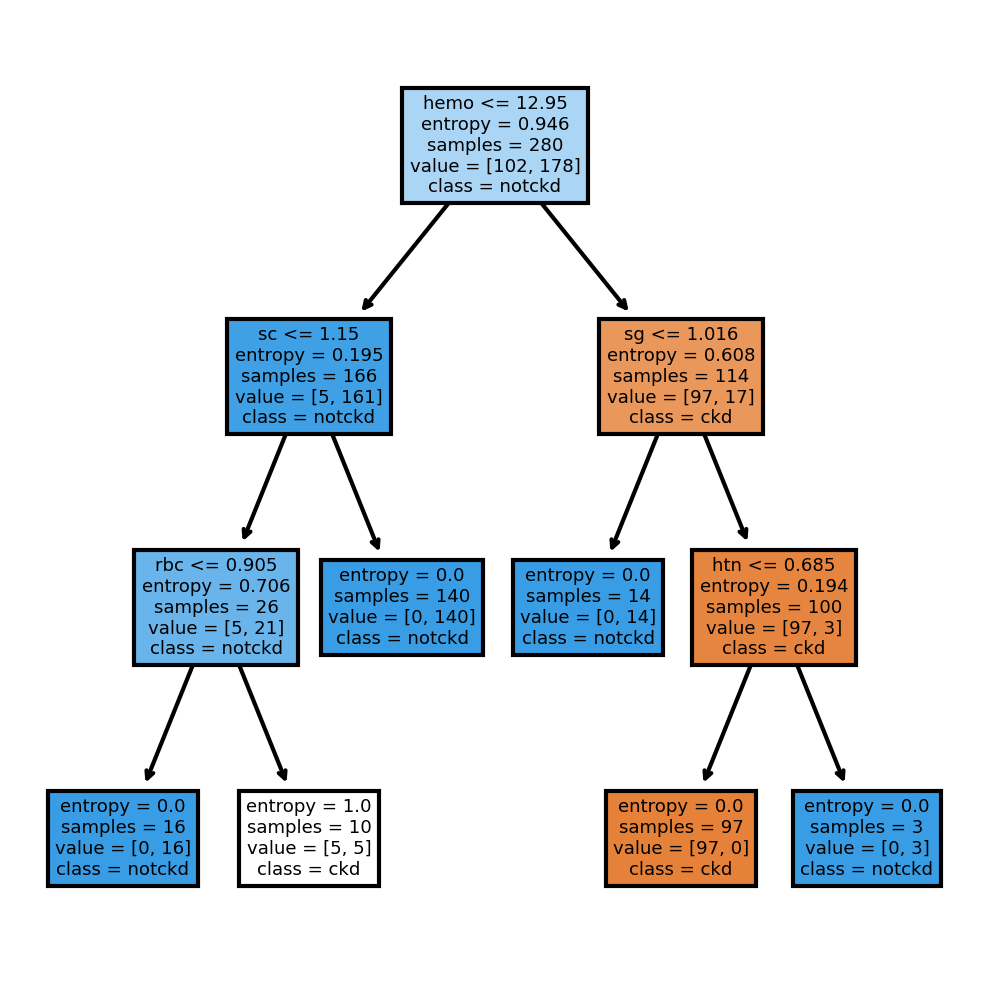

In [ ]:
# Visualization
fig=plt.figure(figsize=(4,4),dpi=300)
fn=['age', 'bp', 'sg', 'al','su','rbc','pc','pcc','ba','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc','htn','dm','cad','appet','pe','ane', 'class']
cn=['ckd', 'notckd']
tree.plot_tree(model_entropy,feature_names=fn,class_names=cn,filled=True)

In [ ]:
y_pred=model_entropy.predict(x_test)
y_pred

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0])

In [ ]:
pd.Series(y_pred).value_counts()

1    71
0    49
dtype: int64

In [ ]:
y_test.value_counts()

1    72
0    48
Name: class, dtype: int64

In [ ]:
pd.crosstab(y_test,y_pred)

col_0,0,1
class,,
0,48,0
1,1,71


In [ ]:
# C5.0 Entropy - Test Model Accuracy
acc = model_entropy.score(x_test,y_test)

In [ ]:
print("Accuracy : ",acc*100,'%')

Accuracy :  99.16666666666667 %


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
gini_coefficient = 2 * roc_auc_score(y_test, y_pred) - 1
print("Accuracy: ", accuracy*100)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F-measure: ", round(f_measure*100,2))
print("AUC: ", round(auc*100,2))
print("Gini coefficient: ", round(gini_coefficient*100,2))

Accuracy:  99.16666666666667
Precision:  100.0
Recall:  98.61111111111111
F-measure:  99.3
AUC:  99.31
Gini coefficient:  98.61


# **LOGISTIC REGRESSION**

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
dataset = pd.read_csv('impckd.csv')

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
gini_coefficient = 2 * roc_auc_score(y_test, y_pred) - 1
print("Accuracy: ", accuracy*100)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F-measure: ", round(f_measure*100,2))
print("AUC: ", round(auc*100,2))
print("Gini coefficient: ", round(gini_coefficient*100,2))

Accuracy:  91.66666666666666
Precision:  91.8918918918919
Recall:  94.44444444444444
F-measure:  93.15
AUC:  90.97
Gini coefficient:  81.94


# **ANN**

In [ ]:

from keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import keras as k
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df=pd.read_csv("impckd.csv")
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.810484,1.0,0.0,0.0,121.000000,...,44.0,7800.0,5.200000,1.0,1.0,0.0,1.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.810484,1.0,0.0,0.0,148.036517,...,38.0,6000.0,4.707435,0.0,0.0,0.0,1.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,1.000000,1.0,0.0,0.0,423.000000,...,31.0,7500.0,4.707435,0.0,1.0,0.0,0.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,1.000000,0.0,1.0,0.0,117.000000,...,32.0,6700.0,3.900000,1.0,0.0,0.0,0.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,1.000000,1.0,0.0,0.0,106.000000,...,35.0,7300.0,4.600000,0.0,0.0,0.0,1.0,0.0,0.0,1


In [ ]:
X = df.drop(["class"], axis=1)
y = df["class"]

In [ ]:
x_scaler = MinMaxScaler()
x_scaler.fit(X)
column_names = X.columns
X[column_names] = x_scaler.transform(X)

In [ ]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=len(X.columns),kernel_initializer=k.initializers.random_normal(seed=13), activation="relu"))
model.add(Dense(1, activation="hard_sigmoid"))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=X_train.shape[0])

Epoch 1/50
1/1 [==============================] - 1s 647ms/step - loss: 0.7167 - accuracy: 0.3812
Epoch 2/50
1/1 [==============================] - 0s 16ms/step - loss: 0.7010 - accuracy: 0.3938
Epoch 3/50
1/1 [==============================] - 0s 15ms/step - loss: 0.6862 - accuracy: 0.5688
Epoch 4/50
1/1 [==============================] - 0s 14ms/step - loss: 0.6720 - accuracy: 0.8875
Epoch 5/50
1/1 [==============================] - 0s 12ms/step - loss: 0.6584 - accuracy: 0.9312
Epoch 6/50
1/1 [==============================] - 0s 13ms/step - loss: 0.6454 - accuracy: 0.8938
Epoch 7/50
1/1 [==============================] - 0s 13ms/step - loss: 0.6330 - accuracy: 0.8531
Epoch 8/50
1/1 [==============================] - 0s 12ms/step - loss: 0.6210 - accuracy: 0.8094
Epoch 9/50
1/1 [==============================] - 0s 12ms/step - loss: 0.6092 - accuracy: 0.8062
Epoch 10/50
1/1 [==============================] - 0s 12ms/step - loss: 0.5976 - accuracy: 0.8156
Epoch 11/50
1/1 [===========

In [ ]:
model.save("ckd.model")

In [ ]:
y_pred=model.predict(X_test)


3/3 [==============================] - 0s 4ms/step


In [ ]:
y_pred = (y_pred >= 0.5).astype(int)


In [ ]:
for i in y_pred:
  if i<=0.5:
    y_pred[i]=0

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
gini_coefficient = 2 * roc_auc_score(y_test, y_pred) - 1
print("Accuracy: ", accuracy*100)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F-measure: ", round(f_measure*100,2))
print("AUC: ", round(auc*100,2))
print("Gini coefficient: ", round(gini_coefficient*100,2))

Accuracy:  97.5
Precision:  100.0
Recall:  96.15384615384616
F-measure:  98.04
AUC:  98.08
Gini coefficient:  96.15


# **SVM**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [ ]:
dataset = pd.read_csv('impckd.csv')

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svm_model = LinearSVC(penalty='l1', dual=False)
svm_model.fit(X_train, y_train)

LinearSVC(dual=False, penalty='l1')

In [ ]:
y_pred = svm_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
gini_coefficient = 2 * roc_auc_score(y_test, y_pred) - 1
print("Accuracy: ", accuracy*100)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F-measure: ", round(f_measure*100,2))
print("AUC: ", round(auc*100,2))
print("Gini coefficient: ", round(gini_coefficient*100,2))

Accuracy:  98.75
Precision:  98.11320754716981
Recall:  100.0
F-measure:  99.05
AUC:  98.21
Gini coefficient:  96.43


In [ ]:
#svm with L2 penalty
svm_model1 = LinearSVC(penalty='l2', dual=False)
svm_model1.fit(X_train, y_train)
y_pred = svm_model1.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
gini_coefficient = 2 * roc_auc_score(y_test, y_pred) - 1
print("Accuracy: ", accuracy*100)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F-measure: ", round(f_measure*100,2))
print("AUC: ", round(auc*100,2))
print("Gini coefficient: ", round(gini_coefficient*100,2))

Accuracy:  98.75
Precision:  100.0
Recall:  98.07692307692307
F-measure:  99.03
AUC:  99.04
Gini coefficient:  98.08


# **KNN**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

np.random.seed(123)


In [ ]:
df=pd.read_csv("impckd.csv")
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0.810484,1.0,0.0,0.0,121.000000,...,44.0,7800.0,5.200000,1.0,1.0,0.0,1.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.810484,1.0,0.0,0.0,148.036517,...,38.0,6000.0,4.707435,0.0,0.0,0.0,1.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,1.000000,1.0,0.0,0.0,423.000000,...,31.0,7500.0,4.707435,0.0,1.0,0.0,0.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,1.000000,0.0,1.0,0.0,117.000000,...,32.0,6700.0,3.900000,1.0,0.0,0.0,0.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,1.000000,1.0,0.0,0.0,106.000000,...,35.0,7300.0,4.600000,0.0,0.0,0.0,1.0,0.0,0.0,1


In [ ]:
x=df.drop(["class"],axis=1)
y=df["class"]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(n_neighbors=5,p=2,metric='euclidean')

In [ ]:
classifier.fit(x_train,y_train)

KNeighborsClassifier(metric='euclidean')

In [ ]:
y_pred=classifier.predict(x_test)

In [ ]:
print(y_pred)

[1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1
 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0
 1 0 0 0 0 0]


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
gini_coefficient = 2 * roc_auc_score(y_test, y_pred) - 1
print("Accuracy: ", accuracy*100)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F-measure: ", round(f_measure*100,2))
print("AUC: ", round(auc*100,2))
print("Gini coefficient: ", round(gini_coefficient*100,2))

Accuracy:  67.5
Precision:  86.11111111111111
Recall:  59.61538461538461
F-measure:  70.45
AUC:  70.88
Gini coefficient:  41.76


# **RANDOM TREE**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df=pd.read_csv("impckd.csv")

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, random_state=1)

In [ ]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [ ]:
y_pred = tree.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred)
f_measure = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
gini_coefficient = 2 * roc_auc_score(y_test, y_pred) - 1
print("Accuracy: ", accuracy*100)
print("Precision: ", precision*100)
print("Recall: ", recall*100)
print("F-measure: ", round(f_measure*100,2))
print("AUC: ", round(auc*100,2))
print("Gini coefficient: ", round(gini_coefficient*100,2))

Accuracy:  98.75
Precision:  100.0
Recall:  98.07692307692307
F-measure:  99.03
AUC:  99.04
Gini coefficient:  98.08
